In [60]:
import numpy as np 
import matplotlib.pyplot as plt
import timing
import astropy.io.fits as pf

%matplotlib inline

Testing...
Generating simulated experiment
Removing baselines
Plotting results


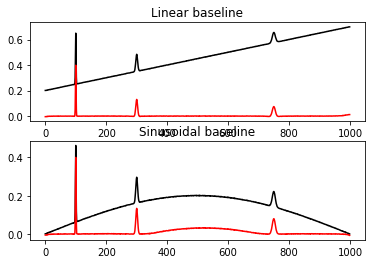

Done!


In [132]:
#By zmzhang https://github.com/zmzhang/airPLS
import numpy as np
from scipy.sparse import csc_matrix, eye, diags
from scipy.sparse.linalg import spsolve

def WhittakerSmooth(x,w,lambda_,differences=1):
    '''
    Penalized least squares algorithm for background fitting
    
    input
        x: input data (i.e. chromatogram of spectrum)
        w: binary masks (value of the mask is zero if a point belongs to peaks and one otherwise)
        lambda_: parameter that can be adjusted by user. The larger lambda is,  the smoother the resulting background
        differences: integer indicating the order of the difference of penalties
    
    output
        the fitted background vector
    '''
    X=np.matrix(x)
    m=X.size
    i=np.arange(0,m)
    E=eye(m,format='csc')
    D=E[1:]-E[:-1] # numpy.diff() does not work with sparse matrix. This is a workaround.
    W=diags(w,0,shape=(m,m))
    A=csc_matrix(W+(lambda_*D.T*D))
    B=csc_matrix(W*X.T)
    background=spsolve(A,B)
    return np.array(background)

def airPLS(x, lambda_=100, porder=1, itermax=15):
    '''
    Adaptive iteratively reweighted penalized least squares for baseline fitting
    
    input
        x: input data (i.e. chromatogram of spectrum)
        lambda_: parameter that can be adjusted by user. The larger lambda is,  the smoother the resulting background, z
        porder: adaptive iteratively reweighted penalized least squares for baseline fitting
    
    output
        the fitted background vector
    '''
    m=x.shape[0]
    w=np.ones(m)
    for i in range(1,itermax+1):
        z=WhittakerSmooth(x,w,lambda_, porder)
        d=x-z
        dssn=np.abs(d[d<0].sum())
        if(dssn<0.001*(abs(x)).sum() or i==itermax):
            if(i==itermax): print ('WARING max iteration reached!')
            break
        w[d>=0]=0 # d>0 means that this point is part of a peak, so its weight is set to 0 in order to ignore it
        w[d<0]=np.exp(i*np.abs(d[d<0])/dssn)
        w[0]=np.exp(i*(d[d<0]).max()/dssn) 
        w[-1]=w[0]
    return z

if __name__=='__main__':
    '''
    Example usage and testing
    '''
    print ('Testing...')
    from scipy.stats import norm
    import matplotlib.pyplot as pl
    x=np.arange(0,1000,1)
    g1=norm(loc = 100, scale = 1.0) # generate three gaussian as a signal
    g2=norm(loc = 300, scale = 3.0)
    g3=norm(loc = 750, scale = 5.0)
    signal=g1.pdf(x)+g2.pdf(x)+g3.pdf(x)
    baseline1=5e-4*x+0.2 # linear baseline
    baseline2=0.2*np.sin(np.pi*x/x.max()) # sinusoidal baseline
    noise=np.random.random(x.shape[0])/500
    print ('Generating simulated experiment')
    y1=signal+baseline1+noise
    y2=signal+baseline2+noise
    print ('Removing baselines')
    c1=y1-airPLS(y1) # corrected values
    c2=y2-airPLS(y2) # with baseline removed
    print ('Plotting results')
    fig,ax=pl.subplots(nrows=2,ncols=1)
    ax[0].plot(x,y1,'-k')
    ax[0].plot(x,c1,'-r')
    ax[0].set_title('Linear baseline')
    ax[1].plot(x,y2,'-k')
    ax[1].plot(x,c2,'-r')
    ax[1].set_title('Sinusoidal baseline')
    pl.show()
    print ('Done!')


In [ ]:
def convert_galactic1950_to_ra_dec(l,b): 
    x0 = np.cos(np.radians(b))*np.cos(np.radians(l))
    x1 = np.cos(np.radians(b))*np.sin(np.radians(l))
    x2 = np.sin(np.radians(b))

    R = np.matrix([[-0.066989,-0.872756,-0.483539],[0.492728,-0.450347,0.744585],[-0.867601,-0.188375,0.460200]])

    x = np.matrix([[x0],[x1],[x2]])

    xp = np.dot(np.transpose(R),x)

    ra =  float(np.degrees(np.arctan2(xp[1],xp[0])))
    dec = float(np.degrees(np.arcsin(xp[2])))

    return ra, dec

def convert_ra_dec_to_az_alt(ra,dec,LST,phi):
    x0 = np.cos(np.radians(dec))*np.cos(np.radians(ra))
    x1 = np.cos(np.radians(dec))*np.sin(np.radians(ra))
    x2 = np.sin(np.radians(dec))

    R0 = np.matrix([[np.cos(np.radians(LST)),np.sin(np.radians(LST)),0],[np.sin(np.radians(LST)),-np.cos(np.radians(LST)),0],[0,0,1]])
    R1 = np.matrix([[-np.sin(np.radians(phi)),0,np.cos(np.radians(phi))],[0,-1,0],[np.cos(np.radians(phi)),0,np.sin(np.radians(phi))]])



    x = np.matrix([[x0],[x1],[x2]])

    xp = np.dot(R1,np.dot(R0,x))

    az =  float(np.degrees(np.arctan2(xp[1],xp[0])))
    alt = float(np.degrees(np.arcsin(xp[2])))

    return az, alt



In [38]:
gal_l = np.linspace(210,20, 191)
gal_b = np.linspace(0,90,91)

target_ra = np.array([])
target_dec = np.array([])
target_az = np.array([])
target_alt = np.array([])

for i,j in zip(gal_l,gal_b):
    ra, dec = convert_galactic1950_to_ra_dec(i,j)
    az, alt = convert_ra_dec_to_az_alt(ra,dec,timing.lst(),37.55)
    
    target_ra = np.append(target_ra, ra)
    target_dec = np.append(target_dec,dec)
    
    target_az = np.append(target_az, az)
    target_alt = np.append(target_alt, alt)

In [74]:
file ='1523376166.71_6.45080082827_62.7257022297.fits'
data = pf.getdata(file)
header = pf.getheader(file)
lol = pf.open(file)

In [131]:
for key in header:
    print(key + ": ", header[key])

SIMPLE:  True
BITPIX:  8
NAXIS:  0
EXTEND:  True
NSPEC:  50
BOFFILE:  spec_ds8_8192.bof
MODE:  spec
FPGA:  192000000.0
IADC:  768000000.0
DOWNSAMP:  8
SAMPRATE:  24000000.0
BW:  12000000.0
NCHAN:  8192
RES:  1464.84375
FFTSHIFT:  16383
ACCLEN:  134217728
INTTIME:  0.6990506666666667
SCALE:  0
L:  119.8729085006556
B:  -0.088720613798643
RA:  6.450800828271027
DEC:  62.72570222965587
JD:  2458219.168645833
UTC:  2018/04/10 16:02:51
TIME:  1523376171.653885


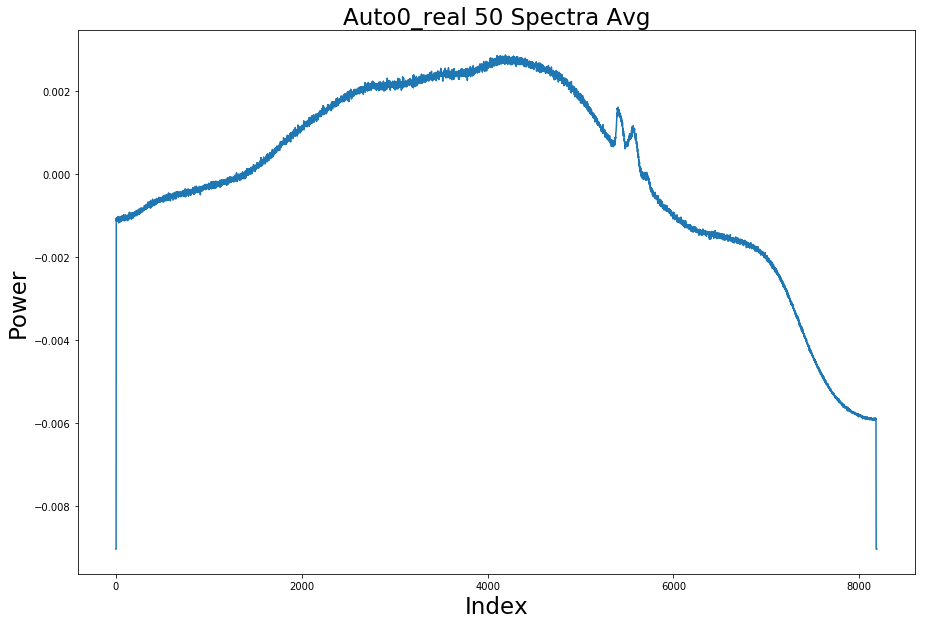

In [217]:

avgspec0 = np.zeros(len(data))
for i in np.arange(50):
    specs = lol[i+1].data['auto0_real']
    avgspec0 = avgspec0 + specs
    
avgspec0 = avgspec0/50
avgspec0 = avgspec0 - np.mean(avgspec0)
plt.figure(figsize=(15,10))
plt.plot(avgspec0)
plt.xlabel('Index',fontsize=23)
plt.ylabel('Power',fontsize=23)
plt.title('Auto0_real 50 Spectra Avg',fontsize=23)
plt.show()

150.0


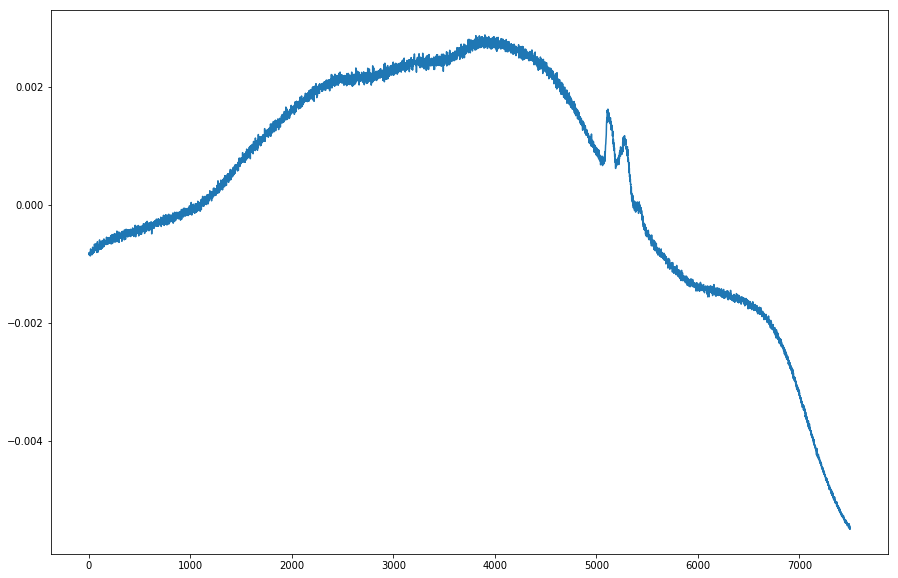

In [218]:
plt.figure(figsize=(15,10))
slice1 = avgspec0[290:7800]
R = len(slice1)%50 
slice1 = slice1[:-R]
print(7500/50)
plt.plot(slice1)
plt.show()

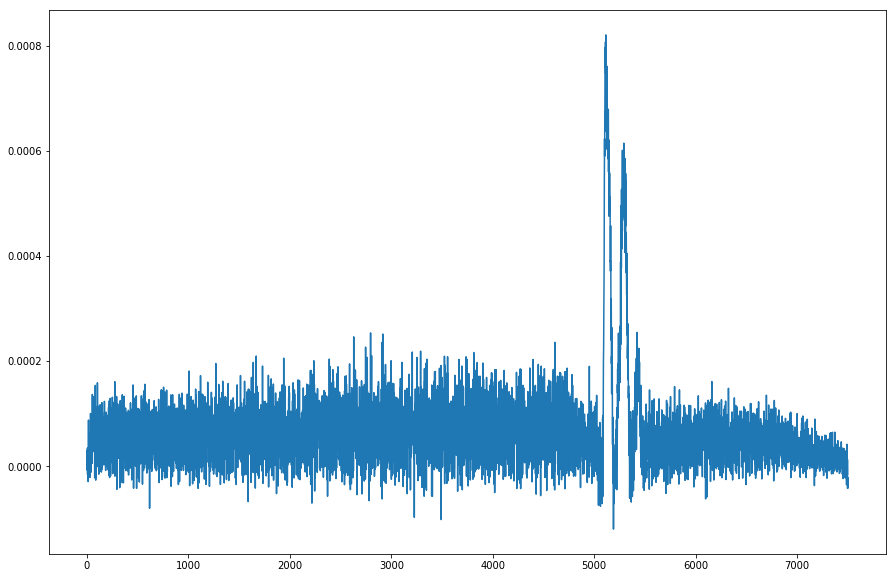

In [219]:

cv = airPLS(slice1)
sub = slice1 - cv
plt.figure(figsize=(15,10))
plt.plot(sub)

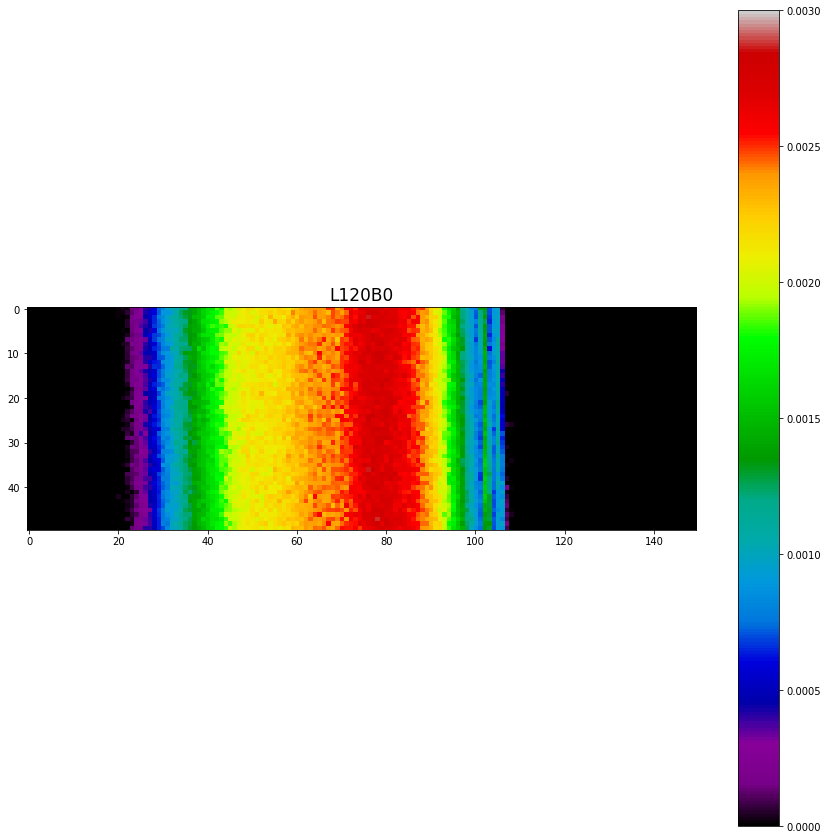

In [221]:

pmin = np.array([])
for i in np.arange(150):
    slices = slice1[50*i:50*(i+1)]#*np.blackman(1187)
    if i == 0:
        pmin = np.append(pmin, slices)
    else:
        pmin = np.vstack((pmin, slices))
        
plt.figure(figsize=(15,15))
plt.imshow(np.rot90(pmin), cmap="hot",clim=(0, .003)).set_cmap('nipy_spectral')
plt.title('L120B0',fontsize=17)
plt.colorbar()
plt.show()

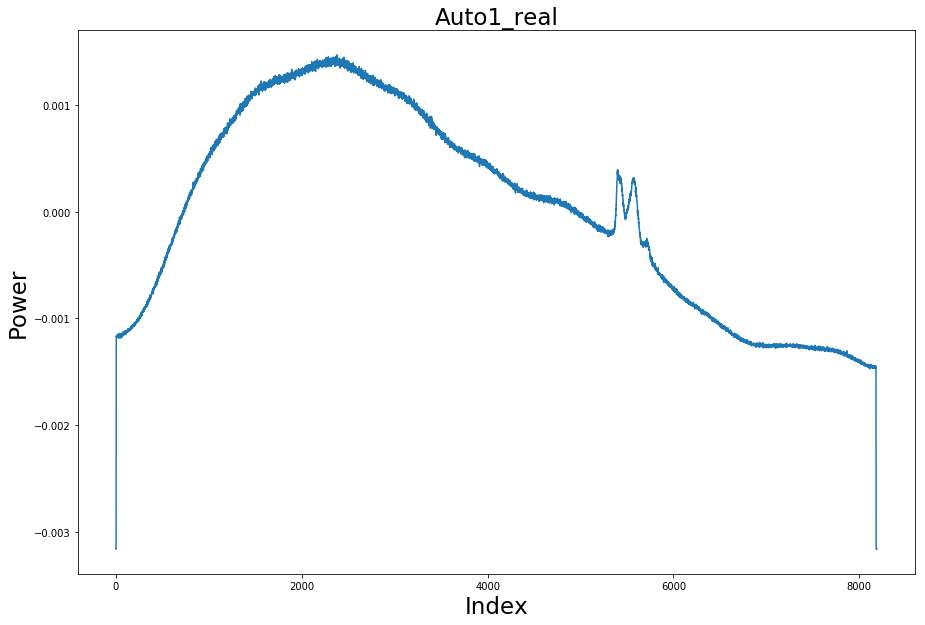

In [129]:

avgspec1 = np.zeros(len(data))
for i in np.arange(50):
    specs = lol[i+1].data['auto1_real']
    avgspec1 = avgspec1 + specs
    
avgspec1 = avgspec1/50
avgspec1 = avgspec1 - np.mean(avgspec1)
plt.figure(figsize=(15,10))
plt.plot(avgspec1)
plt.xlabel('Index',fontsize=23)
plt.ylabel('Power',fontsize=23)
plt.title('Auto1_real',fontsize=23)
plt.show()

In [66]:
data.dtype.names

('auto0_real', 'auto1_real', 'cross_real', 'cross_imag')

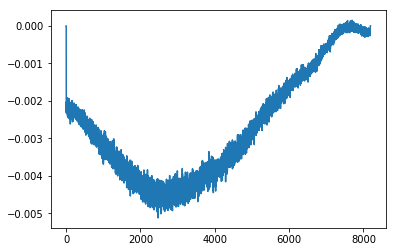

In [203]:
plt.plot(lol[1].data['cross_real'])